In [1]:
from plot_module import save_plot

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv('Monthly_oil_data.csv' , index_col='Production Date', parse_dates=True)

In [3]:
df.head()

,Volume
Production Date,
2015-01-01,67515553.0
2015-02-01,61664960.0
2015-03-01,66342950.0
2015-04-01,67719040.0
2015-05-01,66484591.0


### Train/Test Split

In [4]:
N_test = 12 
train = df.iloc[:-N_test] 
test = df.iloc[-N_test:] 

train_idx = df.index <=train.index[-1] 
test_idx = df.index > train.index[-1]

### Naive forecast

The naive forecast assumes production remains constant from one month to the next. It serves as a minimum benchmark for evaluating more advanced models. Any model that fails to outperform the naive forecast is considered ineffective.

In [5]:
df['VolumePrediction'] = df['Volume'].shift(1)

In [6]:
df.head()

,Volume,VolumePrediction
Production Date,,
2015-01-01,67515553.0,NaN
2015-02-01,61664960.0,67515553.0
2015-03-01,66342950.0,61664960.0
2015-04-01,67719040.0,66342950.0
2015-05-01,66484591.0,67719040.0


In [7]:
y_pred = df.iloc[1:]['VolumePrediction'] 
y_train_pred = y_pred.iloc[:-N_test]
y_test_pred = y_pred.iloc[-N_test:]

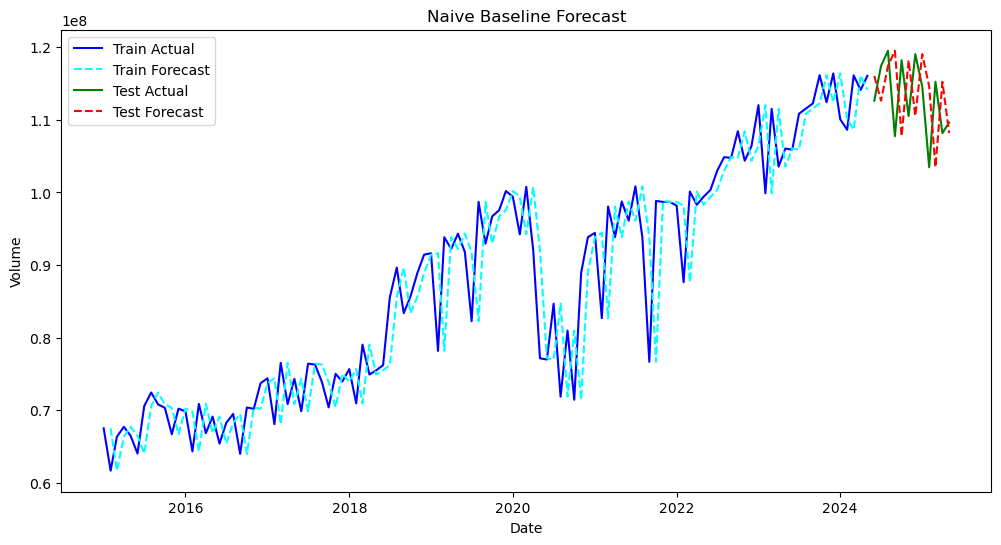

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.index, train, label='Train Actual', color='blue')
ax.plot(y_train_pred.index, y_train_pred, label='Train Forecast', color='cyan', linestyle='--')

ax.plot(test.index, test, label='Test Actual', color='green')
ax.plot(y_test_pred.index, y_test_pred, label='Test Forecast', color='red', linestyle='--')

ax.set_title('Naive Baseline Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
ax.legend();

save_plot(fig, 'Naive forecast')

In [9]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'].iloc[1:], y_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], y_test_pred)))

Train RMSE: 6673210.315199678
Test RMSE: 7925857.24523027


In [10]:
print('Train MAE:', mean_absolute_error(train['Volume'].iloc[1:], y_train_pred))
print('Test MAE:', mean_absolute_error(test['Volume'], y_test_pred))

Train MAE: 4934792.116071428
Test MAE: 7054035.166666667


In [11]:
print('Train R2:', r2_score(train['Volume'].iloc[1:], y_train_pred))
print('Test R2:', r2_score(test['Volume'], y_test_pred))

Train R2: 0.8185829554155855
Test R2: -1.5741518437989686


In [12]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'].iloc[1:], y_train_pred))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], y_test_pred))

Train MAPE: 0.05794392046689214
Test MAPE: 0.06290929000074685


### EWMA

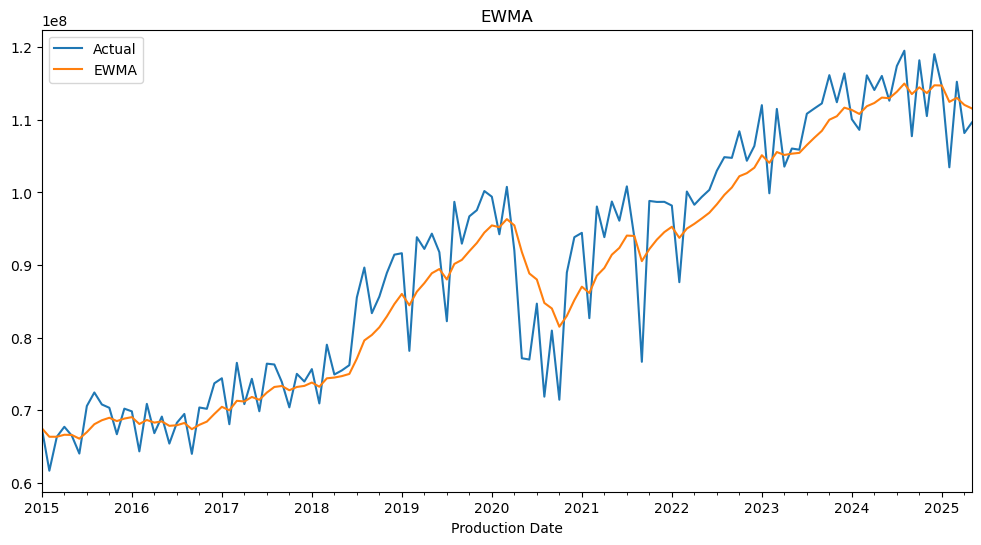

In [13]:
alpha = 0.2
df['EWMA'] = df['Volume'].ewm(alpha = alpha, adjust=False).mean() 
ax = df.plot(y=['Volume', 'EWMA'], figsize=(12,6))
ax.set_title('EWMA')
ax.legend(['Actual', 'EWMA'])

fig = ax.get_figure()
save_plot(fig, 'EWMA')

In [14]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], df['EWMA'].iloc[:-N_test])))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], df['EWMA'].iloc[-N_test:])))

Train RMSE: 4937168.763025521
Test RMSE: 4224877.291323939


In [15]:
print('Train MAE:', mean_absolute_error(train['Volume'],  df['EWMA'].iloc[:-N_test]))
print('Test MAE:', mean_absolute_error(test['Volume'], df['EWMA'].iloc[-N_test:]))

Train MAE: 3975626.419578446
Test MAE: 3548693.139170397


In [16]:
print('Train R2:', r2_score(train['Volume'],  df['EWMA'].iloc[:-N_test]))
print('Test R2:', r2_score(test['Volume'],df['EWMA'].iloc[-N_test:]))

Train R2: 0.9012324305917702
Test R2: 0.26857488432689725


In [17]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'], df['EWMA'].iloc[:-N_test]))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], df['EWMA'].iloc[-N_test:]))

Train MAPE: 0.045616057860307264
Test MAPE: 0.03185274218789833


### SES

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [19]:
df.index.freq = 'MS'  

N_test = 12 
train = df.iloc[:-N_test] 
test = df.iloc[-N_test:] 

train_idx = df.index <=train.index[-1] 
test_idx = df.index > train.index[-1]

ses = SimpleExpSmoothing(train['Volume'], initialization_method='legacy-heuristic') 
res = ses.fit() 

df.loc[train_idx, 'SESfitted'] = res.fittedvalues 
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)

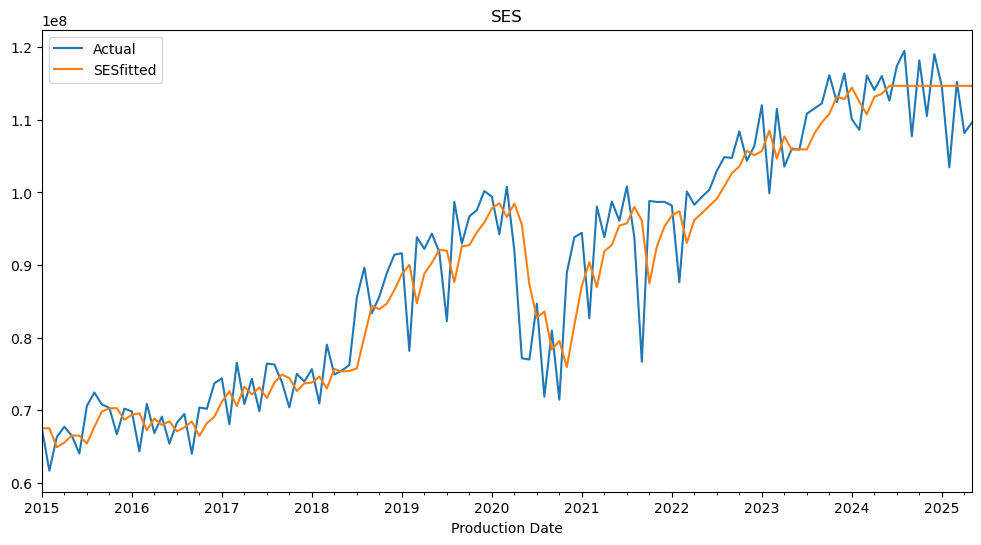

In [20]:
ax = df.plot(y=['Volume', 'SESfitted'], figsize=(12,6))
ax.set_title('SES')
ax.legend(['Actual', 'SESfitted'])

fig = ax.get_figure()
save_plot(fig, 'SES')

In [21]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res.forecast(N_test))))

Train RMSE: 5701867.165526608
Test RMSE: 5213051.49486047


In [22]:
print('Train MAE:', mean_absolute_error(train['Volume'], res.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res.forecast(N_test)))

Train MAE: 4355431.18347914
Test MAE: 4335954.4991718875


In [23]:
print('Train R2:', r2_score(train['Volume'], res.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res.forecast(N_test)))

Train R2: 0.8682675976238147
Test R2: -0.11359096728501483


In [24]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'], res.fittedvalues))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], res.forecast(N_test)))

Train MAPE: 0.05086586962694026
Test MAPE: 0.03922504377855113


### Holt

In [25]:
from statsmodels.tsa.holtwinters import Holt

In [26]:
holt = Holt(train['Volume'], initialization_method='legacy-heuristic') 
res_h = holt.fit() 

df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

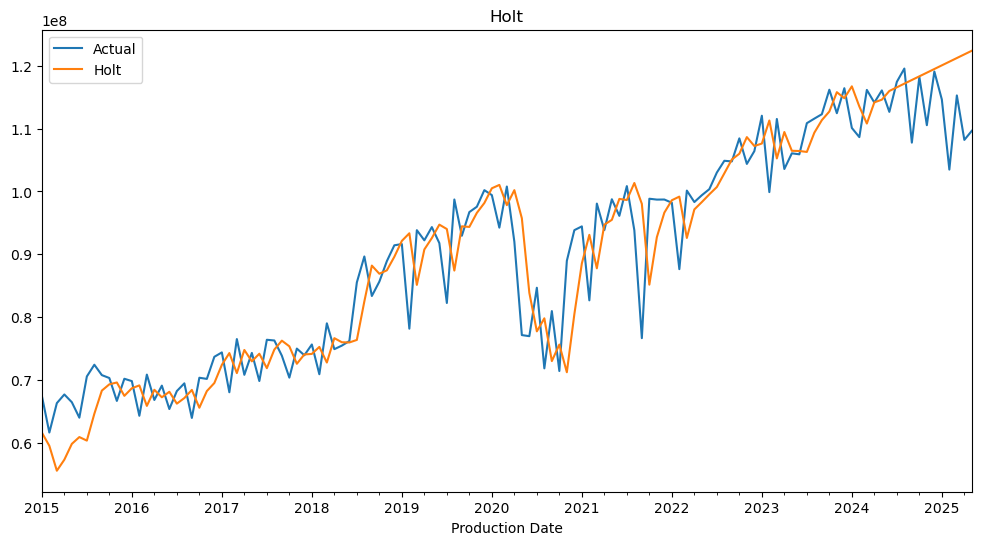

In [27]:
ax = df.plot(y=['Volume', 'Holt'], figsize=(12,6))
ax.set_title('Holt')
ax.legend(['Actual', 'Holt'])

fig = ax.get_figure()
save_plot(fig, 'Holt')

In [28]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_h.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_h.forecast(N_test))))

Train RMSE: 6273553.925687219
Test RMSE: 8624220.889348267


In [29]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_h.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_h.forecast(N_test)))

Train MAE: 4685423.638309482
Test MAE: 6686203.897389203


In [30]:
print('Train R2:', r2_score(train['Volume'], res_h.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_h.forecast(N_test)))

Train R2: 0.8405275406378807
Test R2: -2.0477645450060793


In [31]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'], res_h.fittedvalues))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], res_h.forecast(N_test)))

Train MAPE: 0.056182838265323845
Test MAPE: 0.061290857054734915


### Holt-Winters

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Additive Trend + Seasonality

In [33]:
hw = ExponentialSmoothing(train['Volume'], initialization_method='legacy-heuristic',
                         trend='add', seasonal='add', seasonal_periods=12) 
res_hw = hw.fit() 
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues 
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

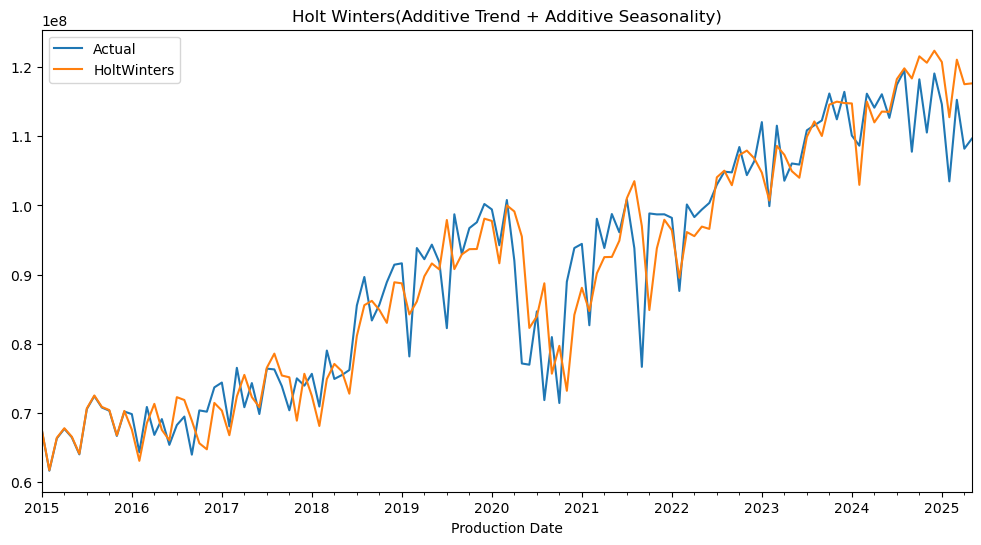

In [34]:
ax = df.plot(y=['Volume', 'HoltWinters'], figsize=(12,6))
ax.set_title('Holt Winters(Additive Trend + Additive Seasonality)')
ax.legend(['Actual', 'HoltWinters'])

fig = ax.get_figure()
save_plot(fig, 'hw_add')

In [35]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_hw.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_hw.forecast(N_test))))

Train RMSE: 5255490.723052157
Test RMSE: 6737046.936829787


In [36]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_hw.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_hw.forecast(N_test)))

Train MAE: 3528012.8620291688
Test MAE: 5643690.092431731


In [37]:
print('Train R2:', r2_score(train['Volume'], res_hw.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_hw.forecast(N_test)))

Train R2: 0.8880858582068198
Test R2: -0.8598624054886452


In [38]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'], res_hw.fittedvalues))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], res_hw.forecast(N_test)))

Train MAPE: 0.041460463266914147
Test MAPE: 0.051196543969020736


#### Multiplicative Seasonality

In [39]:
hw = ExponentialSmoothing(train['Volume'], initialization_method='legacy-heuristic',
                         trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit() 
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues 
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test) 

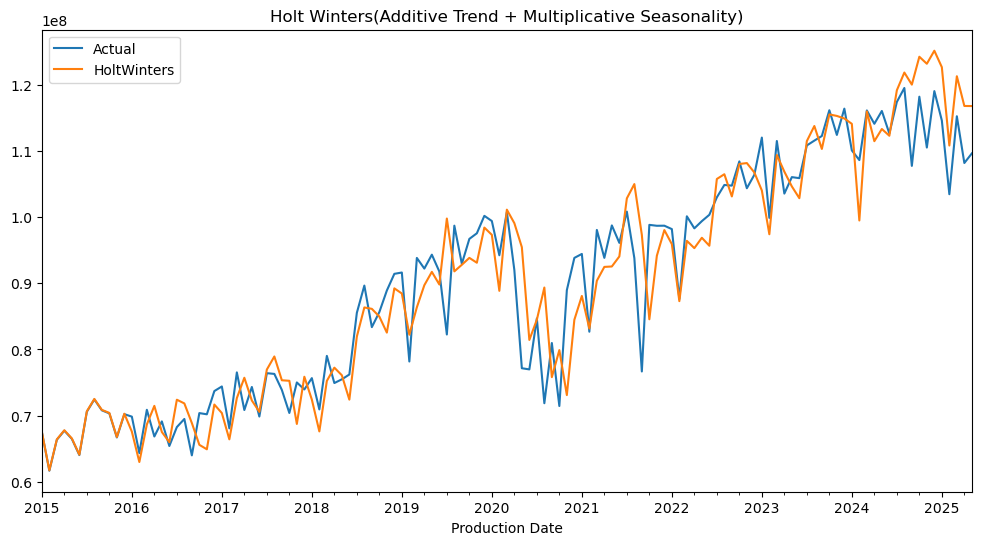

In [40]:
ax = df.plot(y=['Volume', 'HoltWinters'], figsize=(12,6))
ax.set_title('Holt Winters(Additive Trend + Multiplicative Seasonality)')
ax.legend(['Actual', 'HoltWinters'])

fig = ax.get_figure()
save_plot(fig, 'hw_add_mul')

In [41]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_hw.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_hw.forecast(N_test))))

Train RMSE: 5417331.692961109
Test RMSE: 7501740.074637253


In [42]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_hw.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_hw.forecast(N_test)))

Train MAE: 3635092.844755321
Test MAE: 6566245.667440371


In [43]:
print('Train R2:', r2_score(train['Volume'], res_hw.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_hw.forecast(N_test)))

Train R2: 0.8810870164080752
Test R2: -1.3060339372191443


In [44]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'], res_hw.fittedvalues))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], res_hw.forecast(N_test)))

Train MAPE: 0.04251618513360793
Test MAPE: 0.058964006817397385


#### Multiplicative Trend + Seasonality

In [45]:
hw = ExponentialSmoothing(
    train['Volume'], initialization_method='legacy-heuristic', trend='mul',
    seasonal='mul', seasonal_periods=12) 
res_hw = hw.fit() 
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

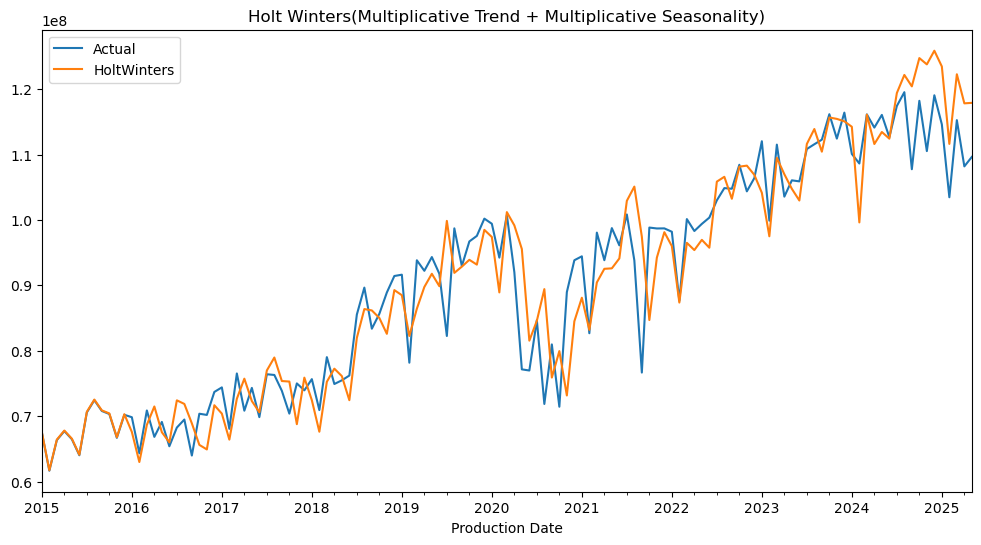

In [46]:
ax = df.plot(y=['Volume', 'HoltWinters'], figsize=(12,6))
ax.set_title('Holt Winters(Multiplicative Trend + Multiplicative Seasonality)')
ax.legend(['Actual', 'HoltWinters'])

fig = ax.get_figure()
save_plot(fig, 'hw_mul')

In [47]:
print('Train RMSE:', np.sqrt(mean_squared_error(train['Volume'], res_hw.fittedvalues)))
print('Test RMSE:', np.sqrt(mean_squared_error(test['Volume'], res_hw.forecast(N_test))))

Train RMSE: 5413625.406644346
Test RMSE: 8120349.211561042


In [48]:
print('Train MAE:', mean_absolute_error(train['Volume'], res_hw.fittedvalues))
print('Test MAE:', mean_absolute_error(test['Volume'], res_hw.forecast(N_test)))

Train MAE: 3621779.8821385945
Test MAE: 7167787.927894617


In [49]:
print('Train R2:', r2_score(train['Volume'], res_hw.fittedvalues))
print('Test R2:', r2_score(test['Volume'], res_hw.forecast(N_test)))

Train R2: 0.8812496702114527
Test R2: -1.7020356967663726


In [50]:
print('Train MAPE:', mean_absolute_percentage_error(train['Volume'], res_hw.fittedvalues))
print('Test MAPE:', mean_absolute_percentage_error(test['Volume'], res_hw.forecast(N_test)))

Train MAPE: 0.04240734342376838
Test MAPE: 0.06434013350540846


### Conclusions

1. EWMA  and Holt–Winters model with additive seasonality perform comparably the best, while the Naive Forecast shows the highest training error.
2. EWMA again records the lowest test errors, demonstrating strong generalization to unseen data, whereas the Holt model appears to perform the worst.